22694617_hlg_1cubes_b65536_mb8064_lr3.2e-4 - episodic_stats/failure_2_last    0.032471
22694616_hlg_1cubes_b65536_mb8064_lr3.2e-4 - episodic_stats/failure_2_last    0.046021
22694614_hlg_1cubes_b65536_mb8064_lr3.2e-4 - episodic_stats/failure_2_last    0.033569
22694613_hlg_1cubes_b65536_mb8064_lr3.2e-4 - episodic_stats/failure_2_last    0.059692
22694615_hlg_1cubes_b65536_mb8064_lr3.2e-4 - episodic_stats/failure_2_last    0.032593
22694605_hlg_1cubes_b65536_mb8064_lr2.7e-4 - episodic_stats/failure_2_last    0.033936
22694604_hlg_1cubes_b65536_mb8064_lr2.7e-4 - episodic_stats/failure_2_last    0.044189
22694603_hlg_1cubes_b65536_mb8064_lr2.7e-4 - episodic_stats/failure_2_last    0.029053
22694602_hlg_1cubes_b65536_mb8064_lr2.7e-4 - episodic_stats/failure_2_last    0.054077
22694601_hlg_1cubes_b65536_mb8064_lr2.7e-4 - episodic_stats/failure_2_last    0.052246
22694598_hlg_1cubes_b65536_mb8064_lr3.7e-4 - episodic_stats/failure_2_last    0.038086
22694597_hlg_1cubes_b65536_mb8064_lr3.7e-4 

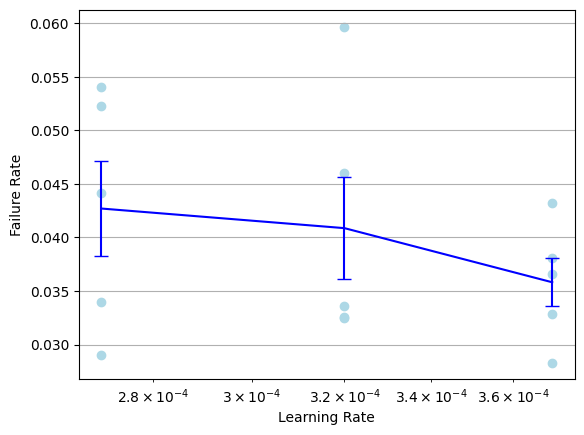

In [8]:
# Plot uncertainty 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import scipy


df = pd.read_csv('data/igpush_b65536.csv')
# df = pd.read_csv('data/igpush_b32768.csv')
# df = pd.read_csv('data/igpush_b16384.csv')
# df = pd.read_csv('data/igpush_b8192.csv')
# df = pd.read_csv('data/igpush_w2048_b8192.csv')
# df = pd.read_csv('data/igpush_w2048_b2048.csv')
# df = pd.read_csv('data/igpush_w2048_b1024.csv')
# df = pd.read_csv('data/igpush_wd2048_b512.csv')

df = df[df['global_step'] < 25*10**8]
df = df.filter(regex='failure_2_last$')
df = df.iloc[-1]
df = df[df.notna()]
data = df.to_dict()
print(df)

# Sort by learning rate
lr_groups = {}
for k, v in data.items():
    lr = float(k.split('lr')[1].split('- episodic')[0].split('_')[0])
    if lr not in lr_groups:
        lr_groups[lr] = []
    lr_groups[lr].append(v)

# Sort by learning rate
lr_groups = dict(sorted(lr_groups.items()))

# Convert lr_groups to format for boxplot
lrs = []
values = []
for lr, vals in lr_groups.items():
    lrs.extend([lr] * len(vals))
    values.extend(vals)

# Calculate mean and SEM for each learning rate group
means = []
sems = []
lrs_unique = []
for lr, vals in lr_groups.items():
    means.append(np.mean(vals))
    sems.append(np.std(vals) / np.sqrt(len(vals)))  # Standard Error of Mean
    lrs_unique.append(lr)

# plot points
plt.figure()
plt.scatter(lrs, values, color='lightblue')
plt.errorbar(lrs_unique, means, yerr=sems, fmt='-', capsize=5, color='blue')
plt.xscale('log')
plt.grid(True)
plt.xlabel('Learning Rate')
plt.ylabel('Failure Rate')
plt.show()




In [9]:
# Get uncertainty-corrected best learning rate
best_lr = lrs_unique[np.argmin(means)]
print(f'Best learning rate: {best_lr:.1e}') 

# Calculate probability of each learning rate being the best 
from scipy.stats import norm
distributions = [norm(np.mean(vals), np.std(vals) / np.sqrt(len(vals))) for vals in lr_groups.values()]

# remember the formula: p(x>y) = cdf((mx - my) / sqrt(varx + vary))
# Calculate probability that each learning rate is better than all others
probabilities = np.ones((len(distributions), len(distributions)))

for i in range(len(distributions)):
    for j in range(len(distributions)):
        if i != j:            
            # Calculate p(x>y) using the formula
            z = (distributions[j].mean() - distributions[i].mean()) / np.sqrt(distributions[i].std()**2 + distributions[j].std()**2)
            probabilities[i,j] = norm.cdf(z)

# Print probability matrix
print("\nProbability matrix (p(row>column)):")
print("LRs:", [f"{lr:.1e}" for lr in lrs_unique])
# print(probabilities)
# Print probabilities each learning rate is the best
best_prob = np.prod(probabilities, axis=1) / np.prod(probabilities, axis=1).sum()
print('probabilities of being the best:', best_prob)
print('approximate best learning rate:', f'{(lrs_unique * best_prob).sum():.2e}')



Best learning rate: 3.7e-04

Probability matrix (p(row>column)):
LRs: ['2.7e-04', '3.2e-04', '3.7e-04']
probabilities of being the best: [0.0355208  0.11534253 0.84913667]
approximate best learning rate: 3.61e-04


1.0

27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in power
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


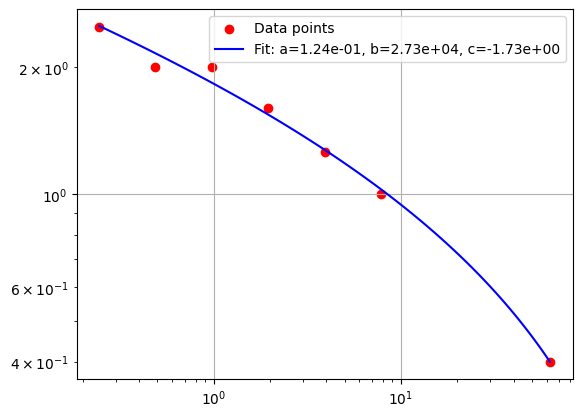

In [4]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


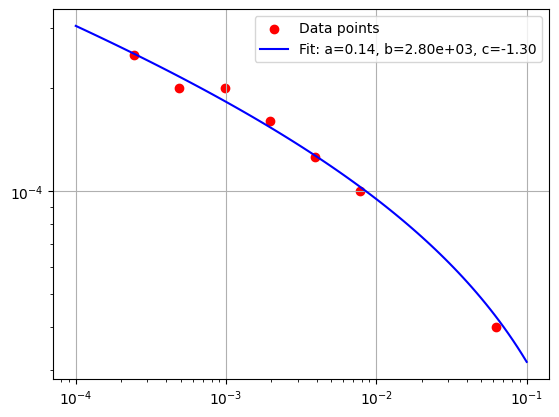

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 121.21it/s]


loss 0.00893393442126563
y = 2.80e+00 / (1 + x/4.80e-01)^-3.56e-01


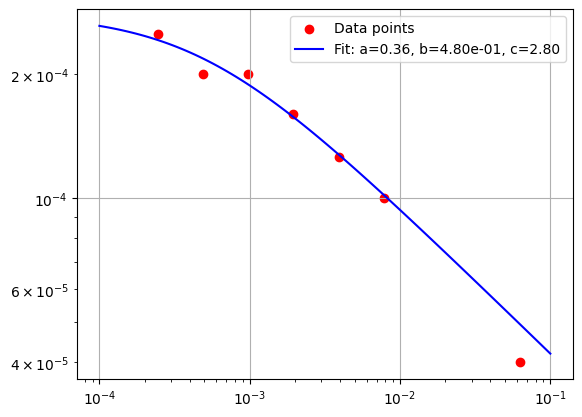

In [32]:
# large-batch training - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/sit

loss 0.41987349469597063
y = 2.00e+00 / (1 + x/1.09e-05)^-8.00e-01


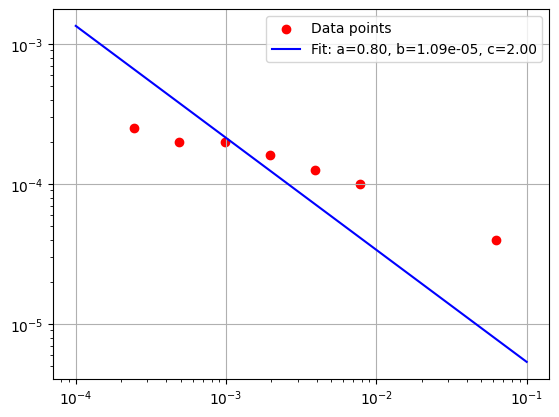

In [30]:
# large-batch training - log space - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((log_lr_rule(x,a,b,c) - np.log(y)) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def log_lr_rule(x, a, b, c):
    return np.log(c) - a * np.log(1 + x/b)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = np.exp(log_lr_rule(x_smooth, a, b, c))

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()